# Further analysis

We now take the ideas from the notes and attempt to understand them

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from matplotlib.cm import get_cmap

# Make the backgrounds non-transparent
sns.set(style='darkgrid')
plt.rc('figure', facecolor='w')

sqlite_url = 'sqlite:///openra-20170606.db'

Let's start with the breakdown of versions of the game used. We see from the database that the `sysinfo` table contains the version of the game played. Let's download this data.

In [2]:
sysinfo = pd.read_sql(
        '''
        SELECT * FROM sysinfo
        WHERE updated IS NOT NULL
        ''', sqlite_url)
sysinfo['updated'] = pd.to_datetime(sysinfo['updated'])
sysinfo['version'] = sysinfo['version'].astype(str)
sysinfo.head()

,system_id,updated,platform,os,runtime,gl,lang,version,mod,modversion,x64,windowsize,windowscale,sysinfoversion
0,9f0d94de-d389-4a0b-9b0e-f19fc9c7164d,2016-04-02 17:50:42,OSX,Unix 15.4.0.0,Mono 4.2.3 (explicit/832de4b Thu Mar 3 19:24:...,2.1 INTEL-10.14.58,en,{DEV_VERSION},cnc,{DEV_VERSION},1,0x0,1,1
1,dd1d8f86-410b-441d-b775-75703e6c7187,2016-04-02 20:37:49,Windows,Microsoft Windows NT 6.1.7600.0,.NET CLR 4.0.30319.17929,3.3.11672 Compatibility Profile Context,de,git-73ec1ec,cd,Closed Beta,1,0x0,1,1
2,5d3e3691-c84b-4868-bd4f-d7d174416652,2016-04-02 21:36:28,Windows,Microsoft Windows NT 6.2.9200.0,.NET CLR 4.0.30319.42000,4.3.12618 Compatibility Profile Context 13.251...,fr,{DEV_VERSION},ts,{DEV_VERSION},1,0x0,1,1
3,8902206f-76a1-4482-bd61-3af19bb28ef6,2016-04-03 00:12:46,Windows,Microsoft Windows NT 6.2.9200.0,.NET CLR 4.0.30319.34209,4.2.0 - Build 10.18.10.3379,de,git-73ec1ec,cd,Closed Beta,1,0x0,1,1
4,89073b99-3eb0-4c66-8e30-a4acf0de6df6,2016-04-03 07:37:44,Linux,Unix 4.2.0.34,Mono 3.2.8 (Debian 3.2.8 dfsg-4ubuntu4) CLR 4....,4.5.0 NVIDIA 352.63,en,{DEV_VERSION},cnc,{DEV_VERSION},1,0x0,1,1


In [3]:
game_versions = sysinfo['version'].dropna().astype(str)
print('Number of unique game versions: {}'.format(len(game_versions.unique())))

Number of unique game versions: 261


Now lots of these versions are a git hash. If we exclude git versions, how many unique versions are there?

In [4]:
git_version = game_versions.str.contains('git')
git_version.unique()

array([False,  True], dtype=bool)

In [5]:
non_git_versions = game_versions[~git_version]
print('Number of git versions: {}'.format(len(game_versions[git_version])))
print('Number of non-git versions: {}'.format(len(non_git_versions)))

non_git_versions.unique()

Number of git versions: 519
Number of non-git versions: 113217


array(['{DEV_VERSION}', 'None', 'playtest-20160403',
       'playtest-20160403~69', '9999', 'playtest-20160424',
       'release-20160508', 'version', '20160513-dev', '20160508',
       'kang-f53ce88', 'kang-6e60aad', 'kang-07ff3d0', 'kang-b7cf0fe',
       'test2', '{GRAND DEVS version by Stas}', 'kang-ec6688e',
       '{SP Build 20160820}', 'kang-3ec642b', 'kang-92ecef6',
       'kang-1b0f309', '{SP Build 20160827}', 'playtest-20160904',
       'AS20160909', 'kang-53e583d', 'kang-3eb0ab9', 'kang-fcba94c',
       'playtest-20161001', 'kang-0a47c51', 'release-20161015',
       'kang-0abe8db', 'release-20161019', '{SP_Build_20161016}',
       'kang-36a13c7', 'kang-fd46a4a', '{SP Build 20160906}',
       'kang-cbcd3b5', 'kang-65d7b09', 'kang-d6397f0', 'kang-3513304',
       'kang-93b015c', '0.0.0.1', 'AS20161120', 'Experimental v2.0',
       'kang-93b015c00', 'kang-d171057', 'AS20170115', 'kang-04a674c',
       'Experimental v2.1', 'Experimental v2.2', 'kang-0cacd2b',
       'Bleed-2017-0

I'm not too familiar with the versioning scheme of OpenRA but judging from the [news feed](http://www.openra.net/news/) the primary releases are either called `release-` or `playtest-`. We can therefore categorise the releases into three groups:

1. Official (named `release-` or `playtest-`)
2. Git
3. Other

It has already been shown that _most_ people are not running of the git branch (519/11372ver6).

In [6]:
def classify_version(version):
    if version is None:
        return 'unknown'
        
    version = str(version)    
    if 'git' in version:
        return 'git'
    elif ('release-' in version or 'playtest-' in version) and not version.startswith('cd'):
        return 'official'
    else:
        return 'unknown'


sysinfo['version_label'] = pd.Categorical(sysinfo['version'].apply(classify_version))


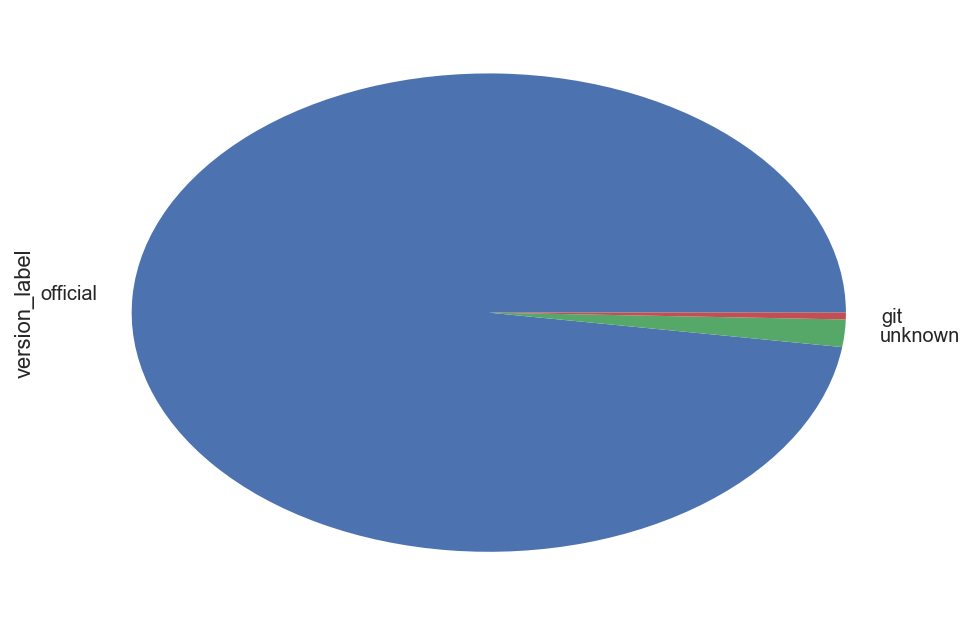

In [17]:
sysinfo['version_label'].value_counts().plot.pie()

We see that the _vast_ majority of people are running the official build. We can focus on the official build.

The official build has the date of release in the title. We start by parsing the release date into a python `date` object.

In [8]:
official_releases = sysinfo[sysinfo['version_label'] == 'official']

In [9]:
def parse_release_date(label):
    # note there is a ~69 in one of the entries. I assume this is some sort of patch release, so we ignore it for now
    date_part = label.split('-')[1].split('~')[0]
    year = int(date_part[:4])
    month = int(date_part[4:6])
    day = int(date_part[6:])
    return datetime.date(year, month, day)

official_releases['release_date'] = official_releases['version'].apply(parse_release_date)

/Users/simon/Documents/Development/openra-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
unique_releases = [val for val in official_releases['release_date'].unique() if val == val]
unique_releases

[datetime.date(2016, 4, 3),
 datetime.date(2016, 4, 24),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 9, 4),
 datetime.date(2016, 10, 1),
 datetime.date(2016, 10, 15),
 datetime.date(2016, 10, 19),
 datetime.date(2017, 3, 3),
 datetime.date(2017, 3, 4),
 datetime.date(2017, 4, 8),
 datetime.date(2017, 4, 21),
 datetime.date(2017, 5, 27)]

12


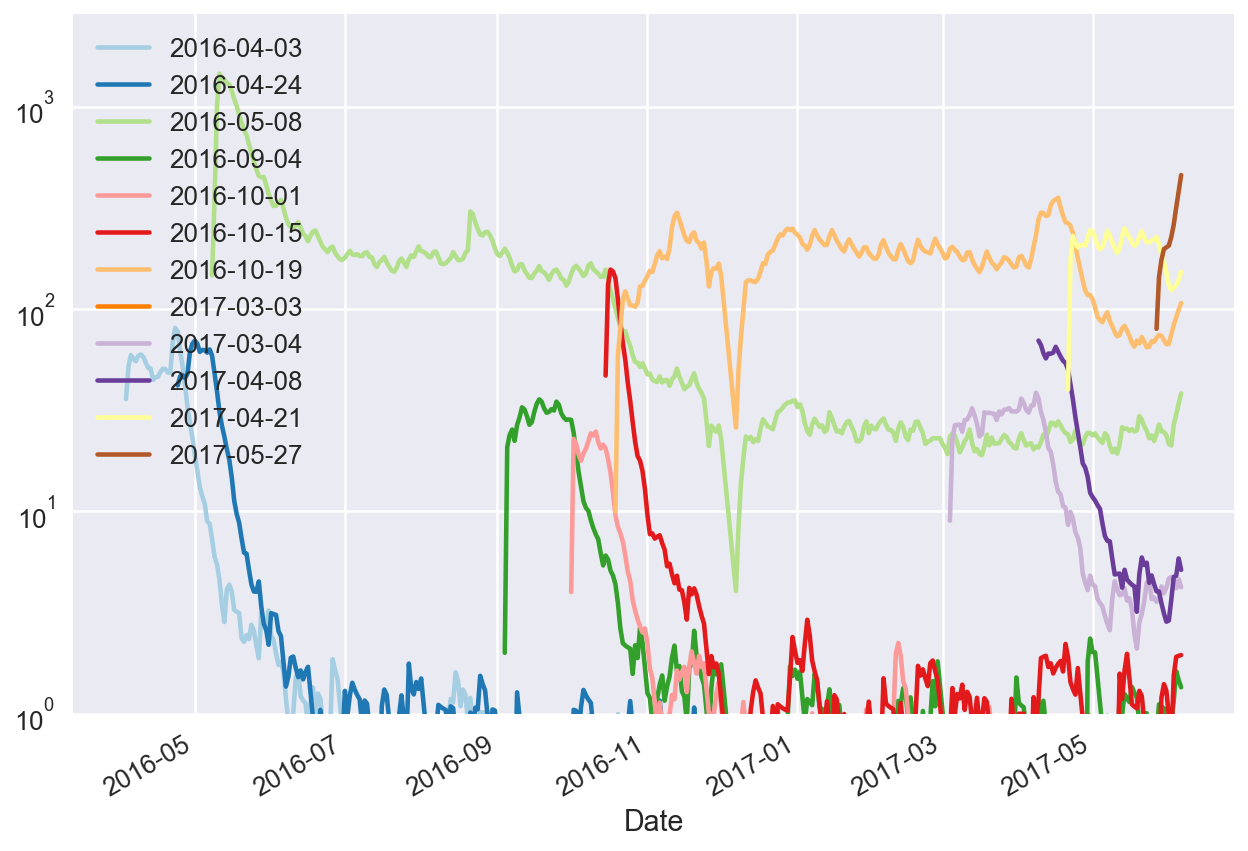

In [43]:
with sns.plotting_context('talk'):
    colour_map = get_cmap('Paired')
    fig, axis = plt.subplots()
    n_unique_releases = len(unique_releases)
    print(n_unique_releases)
    for i, release in enumerate(unique_releases):
        ind = official_releases['release_date'] == release
        subset = official_releases[ind]
        subset = subset.set_index(subset['updated'])
        
        # daily resampling
        resampled = subset.resample('D')['updated'].count()
        
        colour = i / n_unique_releases
        
        # Smoothing
        smoothed = resampled.ewm(com=3).mean()
        axis.semilogy(smoothed.index, smoothed.values, color=colour_map(colour), label=release)
        
    axis.legend(loc='best')
    axis.set(xlabel='Date', ylim=(1, None))
    fig.autofmt_xdate()

We find that new versions tend to have a quick uptake, however version `2016-10-19` has had quite a long life, wth a relatively stable install base. Version `2016-10-15` was quickly overtaken by it's more recent release. Going back to the release notes, there was two critical multiplayer bugs with that version.

It's quite nice to see that xmas is an obvious dip in the player base.